In [1]:
import json
import pandas as pd
from equipartition import Equipartition
import matplotlib.pyplot as plt
import numpy as np
import scipy

from astropy import units as u, constants as c

wtn_z = 0.049

# First, read in the files with the literature best-fit parameters

In [3]:
lit = pd.read_csv("lit_sed_params.csv", comment="#")
bhmasses = pd.read_csv("bh_masses_host.txt", sep="\t")
bhmasses["name"] = bhmasses.name.str.strip()

lit

,Name,t,p,epsilon_e,epsilon_B,nu_a,nu_a_error,nu_m,nu_m_error,Fp_mJy,Fp_mJy_error,dist_Mpc,z
0,CNSSJ0019+00,573,3.3,0.1,0.100,4.260000,0.040000,-99.990000,-99.990000,8.270000,0.030,77.1,0.0180
1,CNSSJ0019+00,606,3.3,0.1,0.100,3.870000,0.030000,-99.990000,-99.990000,8.080000,0.040,77.1,0.0180
2,CNSSJ0019+00,731,3.3,0.1,0.100,3.120000,0.040000,-99.990000,-99.990000,7.410000,0.060,77.1,0.0180
3,CNSSJ0019+00,998,3.3,0.1,0.100,1.920000,0.060000,-99.990000,-99.990000,4.950000,0.090,77.1,0.0180
4,ASASSN-14li,128,3.0,0.1,0.100,16.800000,0.000000,-99.990000,-99.990000,1.910000,0.000,90.0,0.0206
5,ASASSN-14li,143,3.0,0.1,0.100,8.200000,0.100000,-99.990000,-99.990000,1.760000,0.010,90.0,0.0206
6,ASASSN-14li,207,3.0,0.1,0.100,4.370000,0.200000,-99.990000,-99.990000,1.230000,0.030,90.0,0.0206
7,ASASSN-14li,246,3.0,0.1,0.100,4.000000,0.060000,-99.990000,-99.990000,1.140000,0.010,90.0,0.0206
8,ASASSN-14li,304,3.0,0.1,0.100,2.550000,0.060000,-99.990000,-99.990000,0.940000,0.020,90.0,0.0206
9,ASASSN-14li,381,3.0,0.1,0.100,1.910000,0.070000,-99.990000,-99.990000,0.620000,0.020,90.0,0.0206


# Now, use the Equipartition class to compute physical properties of the system

In [5]:
# need to compute
# Req, energyeq, magField, Ne, CNMnumDens and betaeqN

res = []
for name, grp in lit.groupby("Name"):

    if name == "SwJ1644+57": # self.corr = True
        # then this is an on-axis jet
        eq = Equipartition(
            grp.Fp_mJy.values,
            np.maximum(grp.nu_a/10, grp.nu_m/10),
            grp.t,
            nuA10 = grp.nu_a/10,
            nuM10 = grp.nu_m/10,
            z = grp.z.values[0],
            theta = 0,
            p=grp.p,
            epse=0.1, 
            fOmega=1,
            fA=1, 
            fV=0.36, 
            newtonian=False, 
            onAxis=True,
            isoNewtonianNe=False,
            corr=True, 
            outofequipartition=False, 
            factorsFour=False,
            hotprotons= True,
            energysum = False,
            numelectrons=True,
            bothfreq=True,
            BDfactor = False
        )

        eq1 = eq
        t1 = grp.t
        nua_obs = eq.nuA
        num_obs = eq.nuM
        num_pred = eq.num()
        print("measured num\n", eq.nuM)
        print("predicted num\n", eq.num())
    else: # some of the nu_a and nu_m values are just taken to be zero
        eq = Equipartition(
            grp.Fp_mJy.values,
            np.maximum(grp.nu_a/10, grp.nu_m/10),
            grp.t,
            nuA10 = grp.nu_a/10,
            nuM10 = grp.nu_m/10,
            z = grp.z.values[0],
            theta = 0,
            p=grp.p,
            epse=0.1, 
            fOmega=4,
            fA=1, 
            fV=0.36, 
            newtonian=True, 
            isoNewtonianNe=True,
            corr=True, 
            outofequipartition=False, 
            factorsFour=False,
            hotprotons=True,
            energysum = False
        )

        print("Newtonian gamma_m:", eq.gammaM())
        print("calc gamma_m:", eq.gammaM(debug = True))
        print("gamma_m RHS:", 9/32 * eq.epse * eq.mu * (eq.p - 2)/(eq.p - 1) * eq.m_p_cgs/eq.m_e_cgs * eq.betaeqN()**2)
        print("beta:", eq.betaeqN())

    
    grp["gammabeta"] = eq.gammaBeta()
    grp["Req"] = eq.Req()
    grp["Eeq"] = eq.energyeq()
    grp["B"] = eq.magField()
    grp["Ne"] = eq.Ne()
    grp["number_density"] = eq.CNMnumDens()
    res.append(grp)

eq_res = pd.concat(res)

Newtonian gamma_m: 4    2.0
5    2.0
6    2.0
7    2.0
8    2.0
9    2.0
dtype: float64
calc gamma_m: 4    0.035895
5    0.100266
6    0.117953
7    0.094906
8    0.123857
9    0.097204
dtype: float64
gamma_m RHS: 4    0.023509
5    0.073169
6    0.087560
7    0.068858
8    0.092417
9    0.070703
dtype: float64
beta: 4    0.030174
5    0.053233
6    0.058233
7    0.051641
8    0.059826
9    0.052328
dtype: float64
Newtonian gamma_m: 29    2.0
30    2.0
31    2.0
32    2.0
dtype: float64
calc gamma_m: 29    0.072186
30    0.121731
31    0.222430
32    0.174878
dtype: float64
gamma_m RHS: 29    0.064457
30    0.110652
31    0.206384
32    0.160938
dtype: float64
beta: 29    0.073544
30    0.096359
31    0.131598
32    0.116209
dtype: float64
Newtonian gamma_m: 19    2.0
20    2.0
21    2.0
22    2.0
23    2.0
24    2.0
25    2.0
26    2.0
27    2.0
28    2.0
dtype: float64
calc gamma_m: 19    0.188114
20    0.125694
21    0.152304
22    0.174266
23    0.222065
24    0.181218
25    0.1125

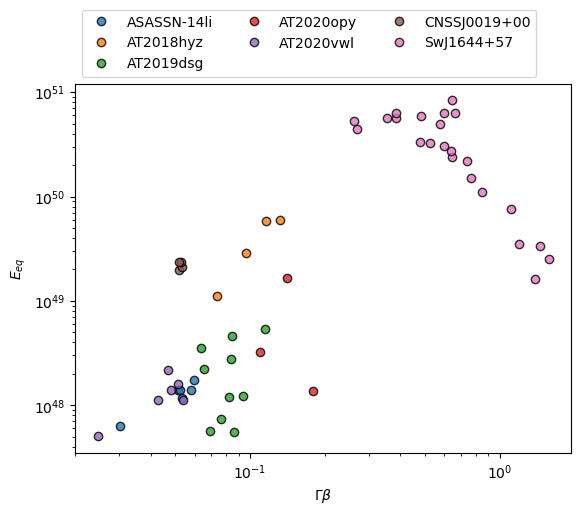

In [6]:
# energy vs gammabeta plot
fig, ax = plt.subplots()
for name, grp in eq_res.groupby("Name"):
    ax.plot(
        grp.gammabeta,
        grp.Eeq,
        marker="o",
        linestyle="none",
        label=name,
        alpha=0.8,
        mec="k"
    )

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylabel(r"$E_{eq}$")
ax.set_xlabel(r"$\Gamma \beta$")
ax.legend(bbox_to_anchor=(0,1),loc="lower left", ncols=3, fontsize=10)

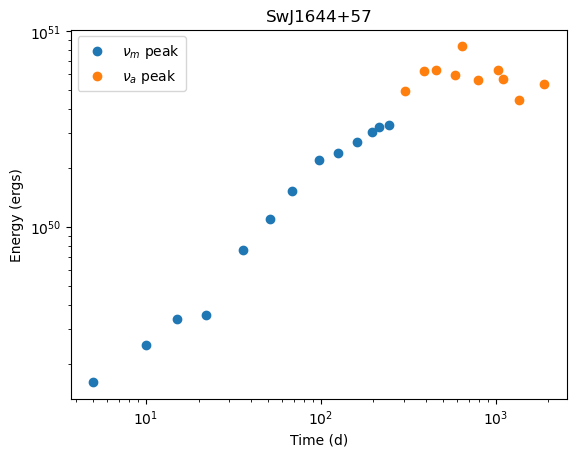

In [7]:
plt.xscale("log")
plt.xlabel("Time (d)")
plt.yscale("log")
plt.ylabel("Energy (ergs)")
plt.title("SwJ1644+57")
numpeak = eq1.nuA10 < eq1.nuM10
nuapeak = np.logical_not(numpeak)
plt.scatter(eq1.tdays[numpeak], eq1.energyeq()[numpeak], label = r"$\nu_m$ peak")
plt.scatter(eq1.tdays[nuapeak], eq1.energyeq()[nuapeak], label = r"$\nu_a$ peak")
plt.legend()

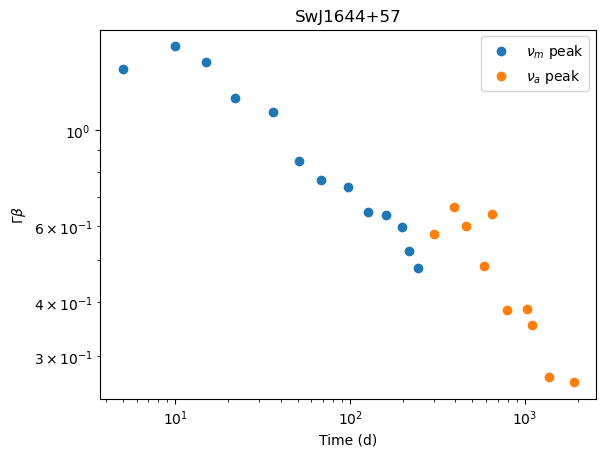

In [8]:
plt.xscale("log")
plt.xlabel("Time (d)")
plt.yscale("log")
plt.ylabel(r"$\Gamma\beta$")
plt.title("SwJ1644+57")
numpeak = eq1.nuA10 < eq1.nuM10
nuapeak = np.logical_not(numpeak)
plt.scatter(eq1.tdays[numpeak], eq1.gammaBeta()[numpeak], label = r"$\nu_m$ peak")
plt.scatter(eq1.tdays[nuapeak], eq1.gammaBeta()[nuapeak], label = r"$\nu_a$ peak")
plt.legend()

In [9]:
argb = np.where(np.equal(eq1.nuA, eq1.nuM))[0][0]
tb = np.array(eq1.tdays)[argb]
nub = np.array(eq1.nup)[argb]

def powerlaw(t, pl, pl2, nub = nub, tb = tb):
    """"""
    return np.where(t < tb, nub * (t/tb)**pl, nub * (t/tb)**pl2)

eq1.tdays = np.array(eq1.tdays)
eq1.nuA = np.array(eq1.nuA)
eq1.nuM = np.array(eq1.nuM)

bounds = [[-np.inf, -np.inf], [0, 0]]

p0A = [-0.7, -0.7]
popta, _ = scipy.optimize.curve_fit(powerlaw, eq1.tdays[1:], eq1.nuA[1:], p0 = p0A, bounds = bounds)
#pla = (np.log(eq1.nuA[argb]) - np.log(eq1.nuA[0]))/(np.log(tb) - np.log(eq1.tdays))
#pl2a = (np.log(eq1.nuA[-1]) - np.log(argb))/(np.log(eq1.tdays) - np.log(tb))
#popta = [1e10, pla, pl2a, tb]

p0B = [-0.7, -0.7]
poptm, _ = scipy.optimize.curve_fit(powerlaw, eq1.tdays, eq1.nuM, p0 = p0B, bounds = bounds)



In [10]:
popta

array([-0.1695058 , -1.11772184])

In [11]:
poptm

array([-1.00937921, -1.87150304])

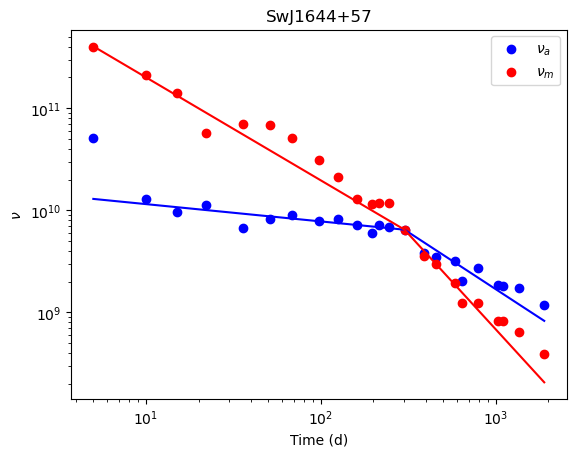

In [12]:
plt.xscale("log")
plt.xlabel("Time (d)")
plt.yscale("log")
plt.ylabel(r"$\nu$")
plt.title("SwJ1644+57")
#numpeak = eq1.nuA10 < eq1.nuM10
#nuapeak = np.logical_not(numpeak)

tdayscont = np.geomspace(np.min(eq1.tdays), np.max(eq1.tdays), 200)

nuAcont = powerlaw(tdayscont, *popta)
plt.plot(tdayscont, nuAcont, color = "b")
plt.scatter(eq1.tdays, eq1.nuA, color = "b", label = r"$\nu_a$")

nuMcont = powerlaw(tdayscont, *poptm)
plt.plot(tdayscont, nuMcont, color = "r")
plt.scatter(eq1.tdays, eq1.nuM, color = "r", label = r"$\nu_m$")

plt.legend()

nuM10cont = nuMcont/1e10
nuA10cont = nuAcont/1e10
nup10cont = np.maximum(nuM10cont, nuA10cont)

In [13]:
Fb = np.array(eq1.FpmJy)[argb]

def powerlawF(t, pl, pl2, Fb = Fb, tb = tb):
    """"""
    return np.where(t < tb, Fb * (t/tb)**pl, Fb * (t/tb)**pl2)

bounds = [[0, -np.inf], [np.inf, 0]]
p0F = [0.7, -0.7]
poptF, _ = scipy.optimize.curve_fit(powerlawF, eq1.tdays[3:], eq1.FpmJy[3:], p0 = p0F, bounds = bounds)
poptF

array([ 0.20083794, -0.95876909])

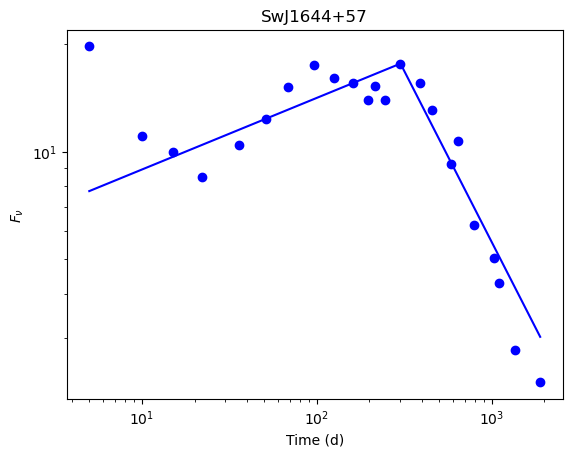

In [14]:
plt.xscale("log")
plt.xlabel("Time (d)")
plt.yscale("log")
plt.ylabel(r"$F_{\nu}$")
plt.title("SwJ1644+57")
#numpeak = eq1.nuA10 < eq1.nuM10
#nuapeak = np.logical_not(numpeak)

tdayscont = np.geomspace(np.min(eq1.tdays), np.max(eq1.tdays), 200)

Fcont = powerlawF(tdayscont, *poptF)
plt.plot(tdayscont, Fcont, color = "b")
plt.scatter(eq1.tdays, eq1.FpmJy, color = "b")

In [15]:
equipcont = Equipartition(
            Fcont,
            nup10cont,
            tdayscont,
            nuA10 = nuA10cont,
            nuM10 = nuM10cont,
            z = eq1.z,
            theta = eq1.theta,
            p=np.array(eq1.p)[0],
            epse=0.1, 
            fOmega=1,
            fA=1, 
            fV=0.36, 
            newtonian=False, 
            onAxis=True,
            isoNewtonianNe=False,
            corr=True, 
            outofequipartition=False, 
            factorsFour=False,
            hotprotons= True,
            energysum = False,
            numelectrons=True,
            bothfreq=True,
            BDfactor = True
        ) # BDfactor = True should theoretically remove discontinuity
equipdiscont = Equipartition(
            Fcont,
            nup10cont,
            tdayscont,
            nuA10 = nuA10cont,
            nuM10 = nuM10cont,
            z = eq1.z,
            theta = eq1.theta,
            p=np.array(eq1.p)[0],
            epse=0.1, 
            fOmega=1,
            fA=1, 
            fV=0.36, 
            newtonian=False, 
            onAxis=True,
            isoNewtonianNe=False,
            corr=True, 
            outofequipartition=False, 
            factorsFour=False,
            hotprotons= True,
            energysum = False,
            numelectrons=True,
            bothfreq=True,
            BDfactor = False
        ) # BDfactor = True should theoretically remove discontinuity
equipdiscontestgammaM = Equipartition(
            Fcont,
            nup10cont,
            tdayscont,
            nuA10 = nuA10cont,
            nuM10 = nuM10cont,
            z = eq1.z,
            theta = eq1.theta,
            p=np.array(eq1.p)[0],
            epse=0.1, 
            fOmega=1,
            fA=1, 
            fV=0.36, 
            newtonian=False, 
            onAxis=True,
            isoNewtonianNe=False,
            corr=True, 
            outofequipartition=False, 
            factorsFour=False,
            hotprotons= True,
            energysum = False,
            numelectrons=True,
            bothfreq=False,
            BDfactor = False
        ) # BDfactor = True should theoretically remove discontinuity

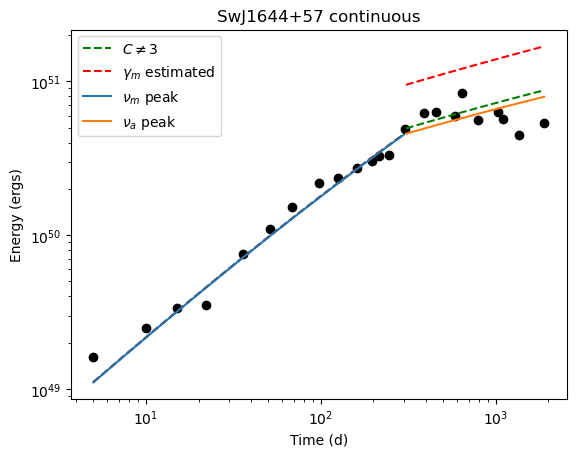

In [16]:
plt.xscale("log")
plt.xlabel("Time (d)")
plt.yscale("log")
plt.ylabel("Energy (ergs)")
plt.title("SwJ1644+57 continuous")
numpeak = equipcont.nuA10 < equipcont.nuM10
nuapeak = np.logical_not(numpeak)
plt.scatter(eq1.tdays, eq1.energyeq(), color = "k")
plt.plot(equipdiscont.tdays[numpeak], equipdiscont.energyeq()[numpeak], linestyle = "--", color = "g", label = r"$C\neq3$")
plt.plot(equipdiscont.tdays[nuapeak], equipdiscont.energyeq()[nuapeak], linestyle = "--", color = "g")
plt.plot(equipdiscontestgammaM.tdays[numpeak], equipdiscontestgammaM.energyeq()[numpeak], linestyle = "--", color = "r", label = r"$\gamma_m$ estimated")
plt.plot(equipdiscontestgammaM.tdays[nuapeak], equipdiscontestgammaM.energyeq()[nuapeak], linestyle = "--", color = "r")
plt.plot(equipcont.tdays[numpeak], equipcont.energyeq()[numpeak], label = r"$\nu_m$ peak")
plt.plot(equipcont.tdays[nuapeak], equipcont.energyeq()[nuapeak], label = r"$\nu_a$ peak")
plt.legend()

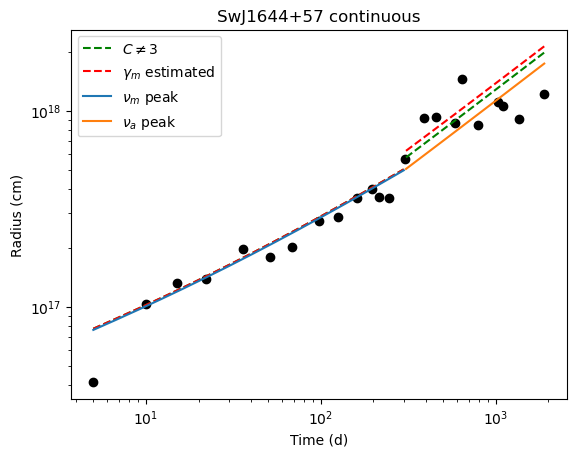

In [17]:
plt.xscale("log")
plt.xlabel("Time (d)")
plt.yscale("log")
plt.ylabel("Radius (cm)")
plt.title("SwJ1644+57 continuous")
numpeak = equipcont.nuA10 < equipcont.nuM10
nuapeak = np.logical_not(numpeak)
plt.scatter(eq1.tdays, eq1.Req(), color = "k")
plt.plot(equipdiscont.tdays[numpeak], equipdiscont.Req()[numpeak], linestyle = "--", color = "g", label = r"$C\neq3$")
plt.plot(equipdiscont.tdays[nuapeak], equipdiscont.Req()[nuapeak], linestyle = "--", color = "g")
plt.plot(equipdiscontestgammaM.tdays[numpeak], equipdiscontestgammaM.Req()[numpeak], linestyle = "--", color = "r", label = r"$\gamma_m$ estimated")
plt.plot(equipdiscontestgammaM.tdays[nuapeak], equipdiscontestgammaM.Req()[nuapeak], linestyle = "--", color = "r")
plt.plot(equipcont.tdays[numpeak], equipcont.Req()[numpeak], label = r"$\nu_m$ peak")
plt.plot(equipcont.tdays[nuapeak], equipcont.Req()[nuapeak], label = r"$\nu_a$ peak")
plt.legend()

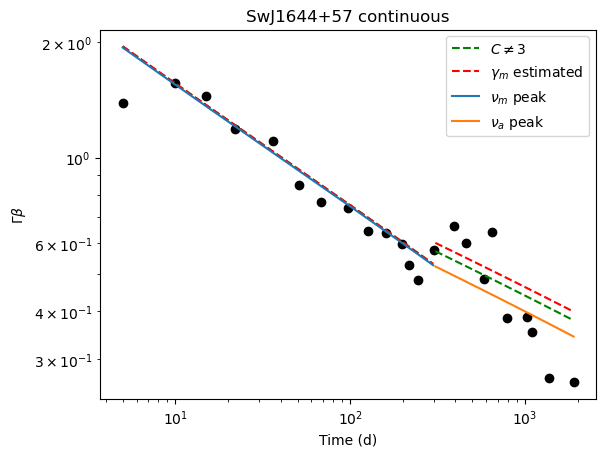

In [18]:
plt.xscale("log")
plt.xlabel("Time (d)")
plt.yscale("log")
plt.ylabel(r"$\Gamma\beta$")
plt.title("SwJ1644+57 continuous")
numpeak = equipcont.nuA10 < equipcont.nuM10
nuapeak = np.logical_not(numpeak)
plt.scatter(eq1.tdays, eq1.gammaBeta(), color = "k")
plt.plot(equipdiscont.tdays[numpeak], equipdiscont.gammaBeta()[numpeak], linestyle = "--", color = "g", label = r"$C\neq3$")
plt.plot(equipdiscont.tdays[nuapeak], equipdiscont.gammaBeta()[nuapeak], linestyle = "--", color = "g")
plt.plot(equipdiscontestgammaM.tdays[numpeak], equipdiscontestgammaM.gammaBeta()[numpeak], linestyle = "--", color = "r", label = r"$\gamma_m$ estimated")
plt.plot(equipdiscontestgammaM.tdays[nuapeak], equipdiscontestgammaM.gammaBeta()[nuapeak], linestyle = "--", color = "r")
plt.plot(equipcont.tdays[numpeak], equipcont.gammaBeta()[numpeak], label = r"$\nu_m$ peak")
plt.plot(equipcont.tdays[nuapeak], equipcont.gammaBeta()[nuapeak], label = r"$\nu_a$ peak")
plt.legend()

ASASSN-14li
AT2018hyz
AT2019dsg
AT2020opy
AT2020vwl
CNSSJ0019+00
SwJ1644+57


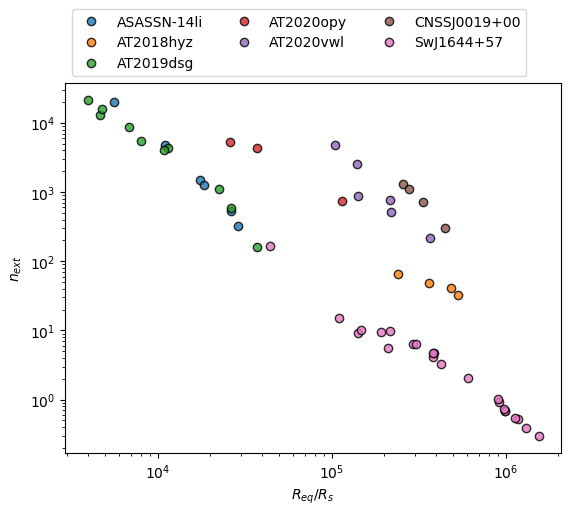

In [19]:
# density vs. radius
fig, ax = plt.subplots()
for name, grp in eq_res.groupby("Name"):
    print(name)
    Mbh = 10**(bhmasses[bhmasses.name == name].bhmass.values[0]) * u.M_sun
    Rs = (2*c.G*Mbh / c.c**2).cgs.value
    ax.plot(
        grp.Req/Rs,
        grp.number_density,
        marker="o",
        linestyle="none",
        label=name,
        alpha=0.8,
        mec="k"
    )

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylabel(r"$n_{ext}$")
ax.set_xlabel(r"$R_{eq} / R_{s}$")
ax.legend(bbox_to_anchor=(0,1),loc="lower left", ncols=3, fontsize=10)

In [20]:
bhmasses.name

0      ASASSN-14ae
1      ASASSN-14li
2         iPTF15af
3      ASASSN-15oi
4        iPTF16axa
5          PS16dtm
6        AT2016fnl
7        AT2017eqx
8         AT2018zr
9        AT2018bsi
10       AT2018dyb
11       AT2018hco
12       AT2018hyz
13       AT2018lna
14     ASASSN-19bt
15       AT2019azh
16       AT2019dsg
17       AT2019ehz
18       AT2019eve
19       AT2019qiz
20       AT2019teq
21        AT2020pj
22       AT2020mot
23       AT2020neh
24       AT2020nov
25       AT2020opy
26       AT2020wey
27       AT2020vwl
28       AT2018fyk
29    CNSSJ0019+00
30      SwJ1644+57
Name: name, dtype: object

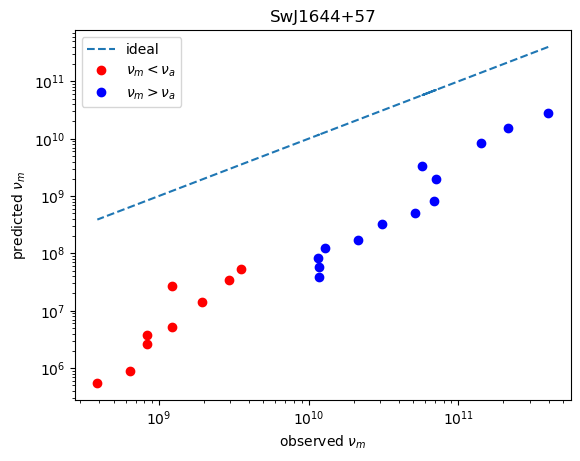

In [21]:
plt.title("SwJ1644+57")
plt.plot(num_obs, num_obs, linestyle = "--", label = "ideal")
plt.plot(num_obs[num_obs < nua_obs], num_pred[num_obs < nua_obs], "ro", label = r"$\nu_m<\nu_a$")
plt.plot(num_obs[num_obs > nua_obs], num_pred[num_obs > nua_obs], "bo", label = r"$\nu_m>\nu_a$")
plt.xscale("log")
plt.xlabel(r"observed $\nu_m$")
plt.ylabel(r"predicted $\nu_m$")
plt.yscale("log")
plt.legend()

In [22]:
def ReqBD13(Fpmjy, dL28, nup10, eta, z, td, fA, fV):
    """"""
    return 7.5e17 * (Fpmjy**(2/3) * dL28**(4/3) * nup10**(-17/12) * (1+z)**(-5/12)) * fA**(-7/12) * fV**(-1/12)

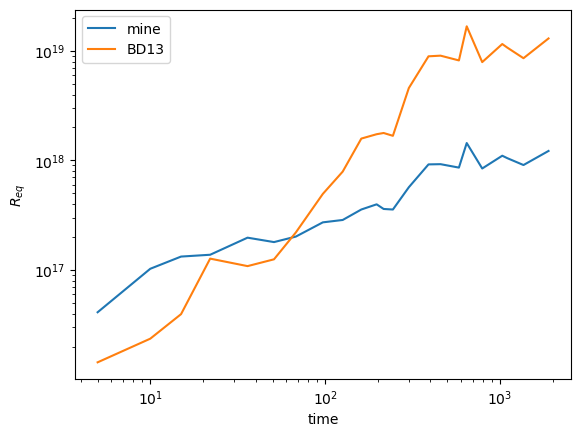

In [23]:
# self.corr = False
plt.plot(t1, eq1.Req(), label = "mine")
plt.plot(t1, ReqBD13(eq1.FpmJy, eq1.dL28, eq1.nup10, eq1.eta(), eq1.z, eq1.tdays, eq1.fA, eq1.fV), label = "BD13")
plt.xscale("log")
plt.xlabel("time")
plt.ylabel(r"$R_{eq}$")
plt.yscale("log")
plt.legend()

In [24]:
N = 50
p = np.concatenate([np.linspace(2, 3, N), np.linspace(2, 3, N)])
nu_a10 = np.concatenate([0.5 * np.ones(N), 1.5 * np.ones(N)])
nu_m10 = np.concatenate([1.5 * np.ones(N), 0.5 * np.ones(N)])
Fp_mJy = np.ones(2 * N)
t = np.ones(2 * N)

eq = Equipartition(
            Fp_mJy,
            np.maximum(nu_a10, nu_m10),
            t,
            nuA10 = nu_a10,
            nuM10 = nu_m10,
            z = 1,
            theta = 0,
            p=p,
            epse=0.1, 
            fOmega=1,
            fA=1, 
            fV=0.36, 
            newtonian=False, 
            onAxis=True,
            isoNewtonianNe=False,
            corr=True, 
            outofequipartition=False, 
            factorsFour=False,
            hotprotons=False,
            numelectrons=True,
            bothfreq=True
        )

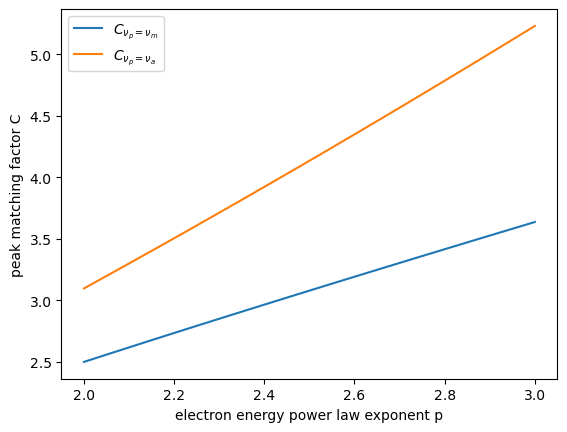

In [25]:
CnumMax = eq.C()[:50]
CnuaMax = eq.C()[50:]
pp = p[:50]

plt.xlabel("electron energy power law exponent p")
plt.ylabel("peak matching factor C")
plt.plot(pp, CnumMax, label = r"$C_{\nu_p=\nu_m}$")
plt.plot(pp, CnuaMax, label = r"$C_{\nu_p=\nu_a}$")
plt.legend()

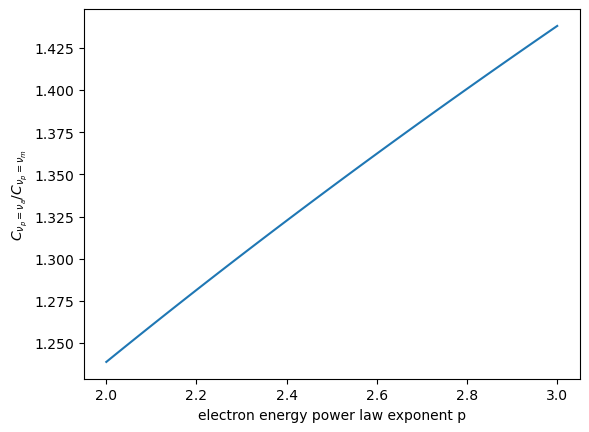

In [26]:
plt.xlabel("electron energy power law exponent p")
plt.ylabel(r"$C_{\nu_p=\nu_a}/C_{\nu_p=\nu_m}$")
plt.plot(pp, CnuaMax/CnumMax)

In [27]:
np.interp(2.5, pp, CnuaMax/CnumMax)

1.342582496556539